In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (r2_score,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             accuracy_score,
                             mean_squared_error,
                             mean_absolute_error)
!pip install phik -q
import phik

# Описание проекта

**К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже.**

**Нам предстоит создать две прогнозные модели для отбора бурёнок в поголовье:**
- Первая будет прогнозировать возможный удой коровы (не менее 6000кг в год);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы.

**Файл ferma_main.csv содержит данные о стаде фермера на текущий момент. Описание данных:**
- id — уникальный идентификатор коровы;
- Удой, кг — масса молока, которую корова даёт в год (в килограммах);
- ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы;
- Сырой протеин, г — содержание сырого протеина в корме (в граммах);
- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы;
- Порода — порода коровы;
- Тип пастбища — ландшафт лугов, на которых паслась корова;
- порода папы_быка — порода папы коровы;
- Жирность,% — содержание жиров в молоке (в процентах);
- Белок,% — содержание белков в молоке (в процентах);
- Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно);
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера. Описание данных:**
- id — уникальный идентификатор коровы;
- Имя Папы — имя папы коровы.

**Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:**
- Порода — порода коровы;
- Тип пастбища — ландшафт лугов, на которых паслась корова;
- порода папы_быка — порода папы коровы;
- Имя_папы — имя папы коровы;
- Текущая_жирность,% — содержание жиров в молоке (в процентах);
- Текущий_уровень_белок,% — содержание белков в молоке (в процентах);
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Данные в файлах ferma_main.csv и cow_buy.csv похожи, но у датасета cow_buy.csv несколько особенностей:**
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм;
- Параметры корма ЭКЕ (Энергетическая кормовая единица);
- Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют;
- Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%;
- Кроме того, отсутствуют признаки Удой, кг и Вкус молока. Это целевые признаки, именно их предстоит предсказать!

# Загрузка данных

**Загрузим данные и взглянем на первые 5 строк.**

In [2]:
df_f = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
df_f.head() #данные о стаде

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [3]:
df_d = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
df_d.head() #данные о пап каждой коровы

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [4]:
df_c = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
df_c.head() #данные о коровах

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


**Теперь посмотрим на всю информацию каждого датасета.**

In [5]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [6]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [7]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**Данных не очень много, что немного облегчит дальнейшую работу. Так же пропусков нет ни в одном датасете, что может не радовать. Но данные нужно проверить ещё подробнее, чтобы избежать ошибок.**

#  Предобработка данных

## Столбцы

**Мы заметили много ошибок в названиях столбов, исправим их. Так же заменим типы данных в некоторых столбцах.**

In [8]:
df_f = df_f.rename(columns={'Удой, кг': 'удой,кг',
                           'ЭКЕ (Энергетическая кормовая единица)': 'ЭКЕ',
                           'Сырой протеин, г': 'сырой_протеин,г',
                           'СПО (Сахаро-протеиновое соотношение)': 'СПО',
                           'Тип пастбища': 'тип_пастбища',
                           'Порода': 'порода',
                           'порода папы_быка': 'порода_папы_быка',
                           'Жирность,%': 'жирность,%',
                           'Белок,%': 'белок,%',
                           'Вкус молока': 'вкус_молока',
                           'Возраст': 'возраст',})

df_d = df_d.rename(columns={'Имя Папы': 'имя_папы'})

df_c = df_c.rename(columns={'Порода': 'порода',
                           'Тип пастбища': 'тип_пастбища',
                           'порода папы_быка': 'порода_папы_быка',
                           'Имя_папы': 'имя_папы',
                           'Текущая_жирность,%': 'текущая_жирность,%',
                           'Текущий_уровень_белок,%': 'текущий_уровень_белок,%',
                           'Возраст': 'возраст',
                           })
display(df_f.columns)
display(df_d.columns)
df_c.columns

Index(['id', 'удой,кг', 'ЭКЕ', 'сырой_протеин,г', 'СПО', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность,%', 'белок,%',
       'вкус_молока', 'возраст'],
      dtype='object')

Index(['id', 'имя_папы'], dtype='object')

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы',
       'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст'],
      dtype='object')

## Дубликаты и пропуски

**Теперь проверим на наличие дубликатов и пропусков(хоть я и сказал выше, что пропусков у нас нет, они могут быть записаны под другими названиями, например `unknown`.**

In [9]:
display(df_f[df_f.duplicated()])
df_f = df_f.drop_duplicates().reset_index(drop=True)

,id,"удой,кг",ЭКЕ,"сырой_протеин,г",СПО,порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


**В датафрейме про стадо мы обнаружили 5 явных дубликатов, причём они находились в конце и шли подряд, скорее всего одну и ту же запись добавили нечаянно несколько раз, от них мы избавились.**

In [10]:
df_c[df_c.duplicated()]

,порода,тип_пастбища,порода_папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


**В датафрейме про коров найдено 4 дубликата, предположительно, это на самом деле не дубликаты. Данных слишком мало и они могли совпасть, к тому же этот датафрейм не будем участвовать в обучении модели.**

In [11]:
df_d.duplicated().sum()

0

**В датафрейме про отцов коров нету дубликатов.**

**Теперь проверим на наличие неявных дубликатов в категориальных признаках.**

In [12]:
object_columns = df_f.select_dtypes(include=['object']).columns.tolist()

print('Датафрейм df_f')
for i in object_columns:
    print(i)
    print(df_f[i].unique())
    print('___')
    
    
object_columns = df_c.select_dtypes(include=['object']).columns.tolist()

print('Датафрейм df_c')
for i in object_columns:
    print(i)
    print(df_c[i].unique())
    print('___')
    
object_columns = df_d.select_dtypes(include=['object']).columns.tolist()

print('Датафрейм df_d')
for i in object_columns:
    print(i)
    print(df_d[i].unique())
    print('___')

Датафрейм df_f
порода
['Вис Бик Айдиал' 'РефлешнСоверинг']
___
тип_пастбища
['Равнинное' 'Равнинные' 'Холмистое']
___
порода_папы_быка
['Айдиал' 'Соверин' 'Айдиалл']
___
вкус_молока
['вкусно' 'не вкусно']
___
возраст
['более_2_лет' 'менее_2_лет']
___
Датафрейм df_c
порода
['Вис Бик Айдиал' 'РефлешнСоверинг']
___
тип_пастбища
['холмистое' 'равнинное']
___
порода_папы_быка
['Айдиал' 'Соверин']
___
имя_папы
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
___
возраст
['более_2_лет' 'менее_2_лет']
___
Датафрейм df_d
имя_папы
['Буйный' 'Соловчик' 'Барин' 'Геркулес']
___


**Обратим внимание, что породы папа-быков Айдиал и Айдиалл - это одно и то же название, дополнительная буква `л` здесь лишняя. Так же неправильное написание типа пастбища - Равнинное и Равнинные. Тип пастбища в разных датафреймах написана по-разному. Испарвим эти моменты.**

In [13]:
df_f['порода_папы_быка'] = df_f['порода_папы_быка'].replace({'Айдиалл': 'Айдиал'})
df_f['тип_пастбища'] = df_f['тип_пастбища'].replace({'Равнинное':'равнинное', 'Равнинные': 'равнинное', 'Холмистое': 'холмистое'})

display(df_f[['тип_пастбища']].value_counts())
df_f[['порода_папы_быка']].value_counts()

тип_пастбища
холмистое       351
равнинное       278
dtype: int64

порода_папы_быка
Айдиал              318
Соверин             311
dtype: int64

**Готово, все данные правильные, пропусков и дубликатов больше нет. Мы привели названия столбцов к единому стандарту и исправили. Так же заменили неправильно заполненные данные.**

# Исследовательский анализ данных

## Графики и выбросы для численных признаков

**Сейчас мы будем выводить графики для численных столбцов. В некоторых моментах мы не будем трогать датафрейм с коровами, которые хочет изучить покупатель(`df_c`), так как там слишком мало данных.**

**Взглянем, сколько удоя чаще всего дают коровы(датафрейм стада).**

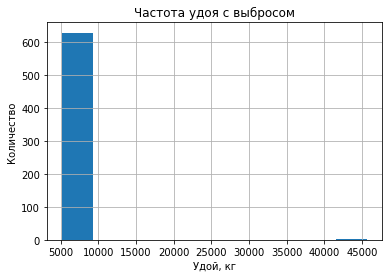

In [14]:
df_f['удой,кг'].hist()
plt.title('Частота удоя с выбросом')
plt.ylabel('Количество')
plt.xlabel('Удой, кг');

**Виден явный выброс, удалим его и по новой выведем графики.**

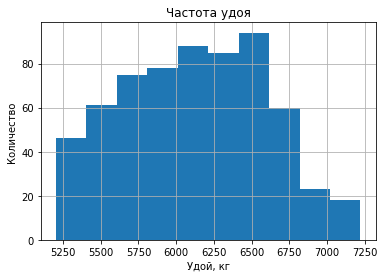

In [15]:
df_f = df_f.query('`удой,кг` < 10000')

df_f['удой,кг'].hist()
plt.title('Частота удоя')
plt.ylabel('Количество')
plt.xlabel('Удой, кг');

**Чаще всего коровы дают удой в промежутке от 5200 до 7000 кг за год, изредка больше 7000 кг за год. Так же у нас есть выброс, 45 тысяч кг удоя за год это невозможно, мы от него избавились.**

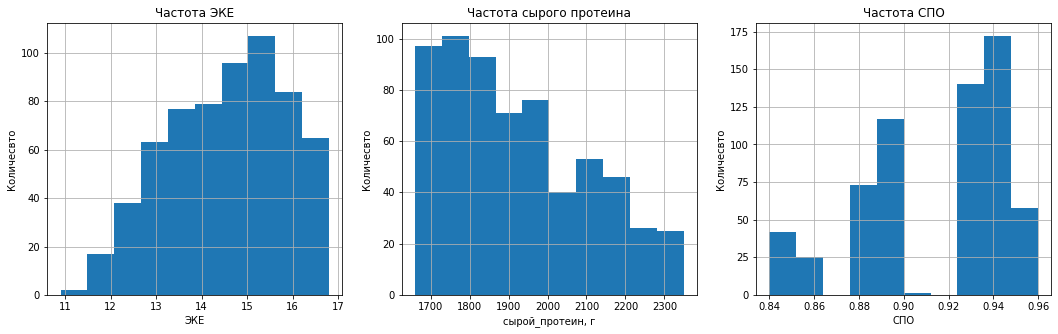

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

df_f['ЭКЕ'].hist(ax=axes[0])
axes[0].set_title('Частота ЭКЕ')
axes[0].set_xlabel('ЭКЕ')
axes[0].set_ylabel('Количесвто')

df_f['сырой_протеин,г'].hist(ax=axes[1])
axes[1].set_title('Частота сырого протеина')
axes[1].set_xlabel('сырой_протеин, г')
axes[1].set_ylabel('Количесвто')

df_f['СПО'].hist(ax=axes[2])
axes[2].set_title('Частота СПО')
axes[2].set_xlabel('СПО')
axes[2].set_ylabel('Количесвто');

- ЭКЕ чаще всего находится в диапазоне от 13.2 до 16.8, за редким исключением ЭКЕ равен 11-11.5. Так же график резко обрывается на значении 16.8, больше корма коровам не дают.
- Сырой протеин в корме чаще всего встречается со значением от 1640 до 1860, далее идёт спад до 2360.
- СПО визуально разделился на 3 группы: с 0.84 до 0.86, с 0.88 до 0.90, с 0.92 до 0.96(чаще всего данные входят в этот диапазон).

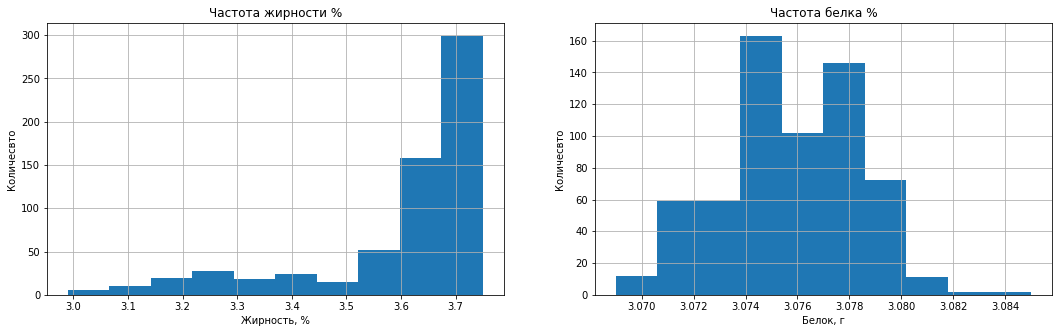

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) 

df_f['жирность,%'].hist(ax=axes[0])
axes[0].set_title('Частота жирности %')
axes[0].set_xlabel('Жирность, %')
axes[0].set_ylabel('Количесвто')

df_f['белок,%'].hist(ax=axes[1])
axes[1].set_title('Частота белка %')
axes[1].set_xlabel('Белок, г')
axes[1].set_ylabel('Количесвто');

- В молоке процент жира находится в диапазоне 3.0%-3.7%, чаще всего значение равно3.7%.
- Белок находится в диапазоне 3.070%-3.084%, диапазон здесь маленький. Чаще всего значение варьируется от 3.074% до 3.078%

**Теперь рассмотрим датафрейм с коровами.**

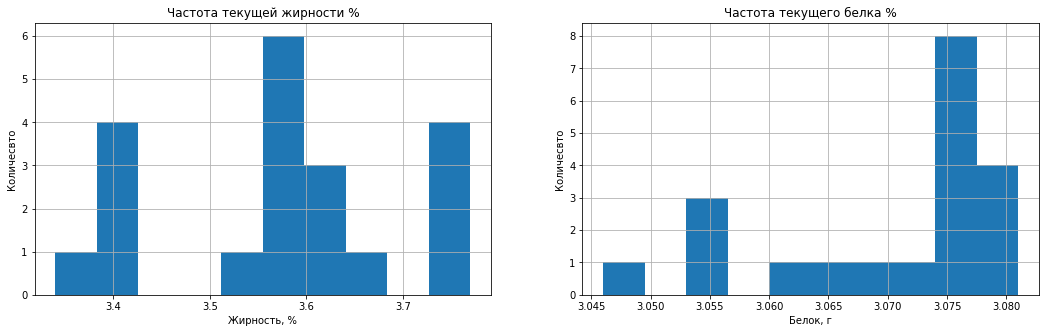

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) 

df_c['текущая_жирность,%'].hist(ax=axes[0])
axes[0].set_title('Частота текущей жирности %')
axes[0].set_xlabel('Жирность, %')
axes[0].set_ylabel('Количесвто')

df_c['текущий_уровень_белок,%'].hist(ax=axes[1])
axes[1].set_title('Частота текущего белка %')
axes[1].set_xlabel('Белок, г')
axes[1].set_ylabel('Количесвто');

**Данных слишком мало, чтобы делать выводы о рапределении, главное, что у нас нет выбросов и значения находятся в тех же диапазонах, что и в основной таблице.**

**Численные данные рассмотрены:**
- Выброс лишь 1 - у одной коровы был обнаружен 45 тысяч кг удоя за год;
- Коровы дают от 5200 кг до 7000 кг за год;
- ЭКЕ чаще находится в диапазоне от 13.2 до 16.8;
- Сырой протеин чаще встречается со значение 1640 до 1860;
- СПО визуально разделился на 3 группы: с 0.84 до 0.86, с 0.88 до 0.90, с 0.92 до 0.96(последний самый частый);
- В молоке процент жира находится в диапазоне 3.0%-3.7%, на моменд продажи поделился три группы(выделю пики): 3.40%, 3.8%, 3.75%
- Белок в диапазоне 3.070%-3.084%, на моменд продажи так же поделился на три группы(выделю пики по увеличению):  3.047%, 3.055%, 3.077%.

## Ящик с усами

**Создадим ящик с усами для численных данных.**

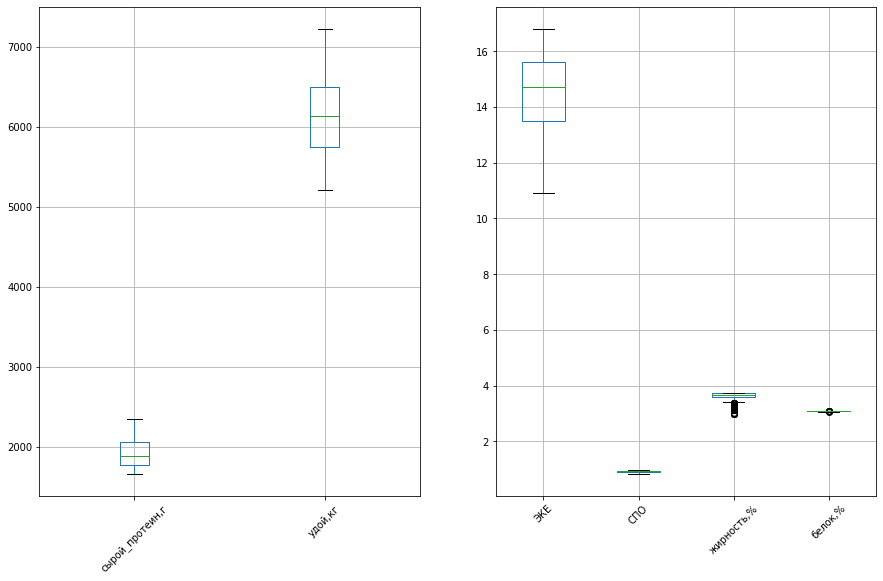

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

df_f_q = df_f[['сырой_протеин,г', 'удой,кг']]
df_f_q.boxplot(ax=axes[0])
axes[0].tick_params(axis='x', rotation=45);

df_f_q = df_f[['ЭКЕ', 'СПО', 'жирность,%', 'белок,%']]
df_f_q.boxplot(ax=axes[1])
axes[1].tick_params(axis='x', rotation=45);

**Выбросов нет, все данные очень хорошие, кроме жирности, там большинство данных узоходит вниз от ящика.**

## Графики и выбросы для категориальных признаков

**Создадим три круговые диаграммы: порода, тип пастбища и порода папы быка.**

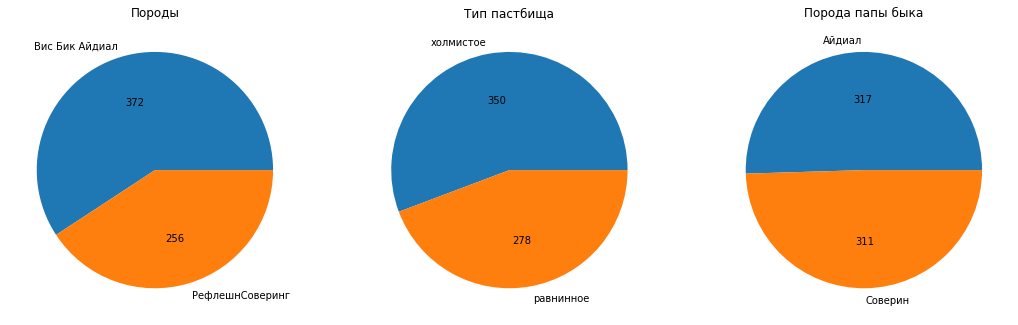

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 9)) 

 
def piee(df, i, name):                #функция для построения круговой диаграммы
    df_f_q.plot(kind='pie',
            y='count', 
            labels=df_f_q.index,
            legend=False, 
            autopct=lambda x: '{:.0f}'.format(x * sum(df_f_q.values)/100), ax=axes[i])
    axes[i].set_ylabel('') 
    axes[i].set_title(name);

df_f_q = (df_f.groupby('порода')['тип_пастбища']     
                        .count()
                        .sort_values(ascending=False))
piee(df_f_q, 0, 'Породы') #1 график


df_f_q = (df_f.groupby('тип_пастбища')['порода_папы_быка']   
                        .count()
                        .sort_values(ascending=False))
piee(df_f_q, 1, 'Тип пастбища') #2 график

df_f_q = (df_f.groupby('порода_папы_быка')['порода']
                        .count()
                        .sort_values(ascending=False))
piee(df_f_q, 2, 'Порода папы быка') #3 график

- Чаще всего корова имеет породу `Вис Бик Айдиал`, посётся на `холмистой` местности и его папа имеет породы `Соверин` или `Айдиал`.
- Неменого реже имеет породу `РефлешнСоверинг`, посётся на `равнине`, а его папа так же породы `Соверин` или `Айдиал`.

**Теперь создадим две диаграммы по вкусу молока и возрасту.**

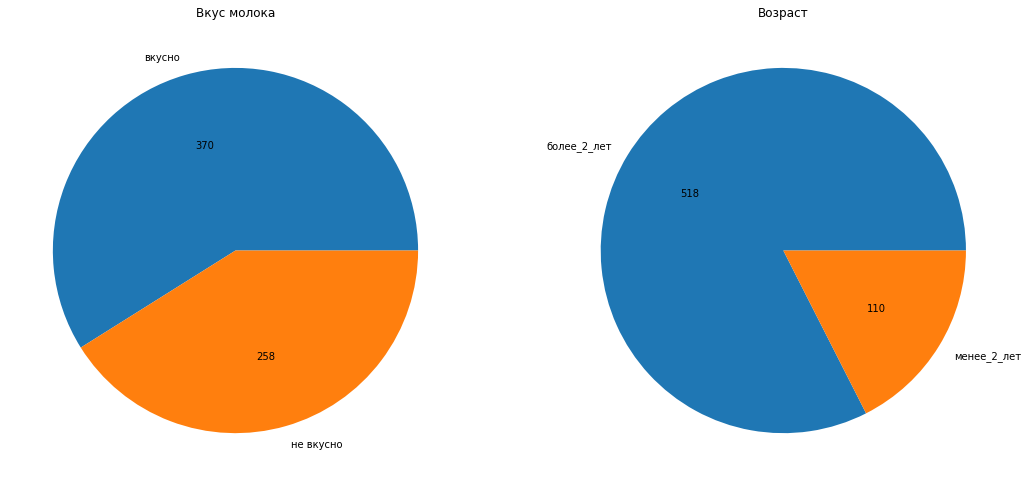

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))
df_f_q = (df_f.groupby('вкус_молока')['тип_пастбища']     
                        .count()
                        .sort_values(ascending=False))
piee(df_f_q, 0, 'Вкус молока') #1 график

df_f_q = (df_f.groupby('возраст')['тип_пастбища']     
                        .count()
                        .sort_values(ascending=False))
piee(df_f_q, 1, 'Возраст') #2 график

**Большинство коров старше 2 лет(соотношение 5:1), а вкус чаще всего вкусный(371 против 258).**

**Так же ради интереса посмотрим на имена папы быков.**

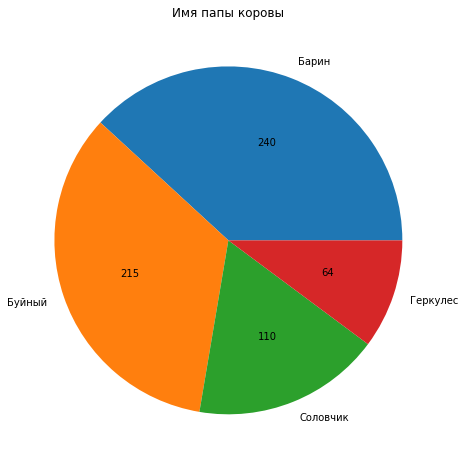

In [22]:
df_f_q = (df_d.groupby('имя_папы')['id']     
                        .count()
                        .sort_values(ascending=False))

df_f_q.plot(kind='pie',
            y='count', 
            labels=df_f_q.index,
            legend=False, 
            autopct=lambda x: '{:.0f}'.format(x * sum(df_f_q.values)/100),
            figsize=(18, 8))
plt.ylabel('') 
plt.title('Имя папы коровы');

**Есть две породы: `Вис Бик Айдиал` и `РефлешнСоверинг`, первой немного больше. коровы почаще пасуться на холмистой местности, нежели на равнине, а папы имеют породу `Соверин` или `Айдиал`(кстати, чаще всего его зовут `Барин` или `Буйный`). Вкус большинство коров старше 2 лет(их в 5 раз больше, чем молодых), а вкус молока чаще вкусный(371), нежели не вкусный(258).**

**Данные проанализированы, подведём итоги.**

**Численные данные:**
- Выброс лишь 1 - у одной коровы был обнаружен 45 тысяч кг удоя за год;
- Коровы дают от 5200 кг до 7000 кг за год;
- ЭКЕ чаще находится в диапазоне от 13.2 до 16.8;
- Сырой протеин чаще встречается со значение 1640 до 1860;
- СПО визуально разделился на 3 группы: с 0.84 до 0.86, с 0.88 до 0.90, с 0.92 до 0.96(последний самый частый);
- В молоке процент жира находится в диапазоне 3.0%-3.7%, на моменд продажи поделился три группы(выделю пики): 3.40%, 3.8%, 3.75%
- Белок в диапазоне 3.070%-3.084%, на моменд продажи так же поделился на три группы(выделю пики по увеличению):  3.047%, 3.055%, 3.077%.

**Категориальные данные:**
- Есть две породы коровы(Вис Бик Айдиал и РефлешнСоверинг), два типа пастбища(холмистая и равнина) и папы-быки бывают породы(Соверин и Айдиал). В большинстве случаев первая позиция появляется в датафрейме почаще второй;
- Вкус молока чаще вкусный - 371, но не вкусных тоже не мало - 258;
- Большинство коров старше двух лет с соотношением к молодым 5:1.

# Корреляционный анализ

## Корреляция стада

**Посмотрим на корреляцию в датафрейме стада.**

In [23]:
df_f.phik_matrix(interval_cols=['удой,кг', 'ЭКЕ', 'сырой_протеин,г',
      'СПО', 'жирность,%', 'белок,%'])

,id,"удой,кг",ЭКЕ,"сырой_протеин,г",СПО,порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст
id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
"удой,кг",1.0,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101
ЭКЕ,1.0,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596
"сырой_протеин,г",1.0,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685
СПО,1.0,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410
порода,1.0,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295
тип_пастбища,1.0,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455
порода_папы_быка,1.0,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817
"жирность,%",1.0,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913
"белок,%",1.0,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000


**Видно, что все признакми имеют высокую корреляцию с целевым признаком(удой), но порода, белок и	вкус_молока имеют слабую связь. Мультиколлениарности нет.**

**Создадим графики корреляции удоя с другими количественными признаками, учитывая категориальные признаки.**

**Графиков будет много, начнём со связи удой и ЭКЕ.**

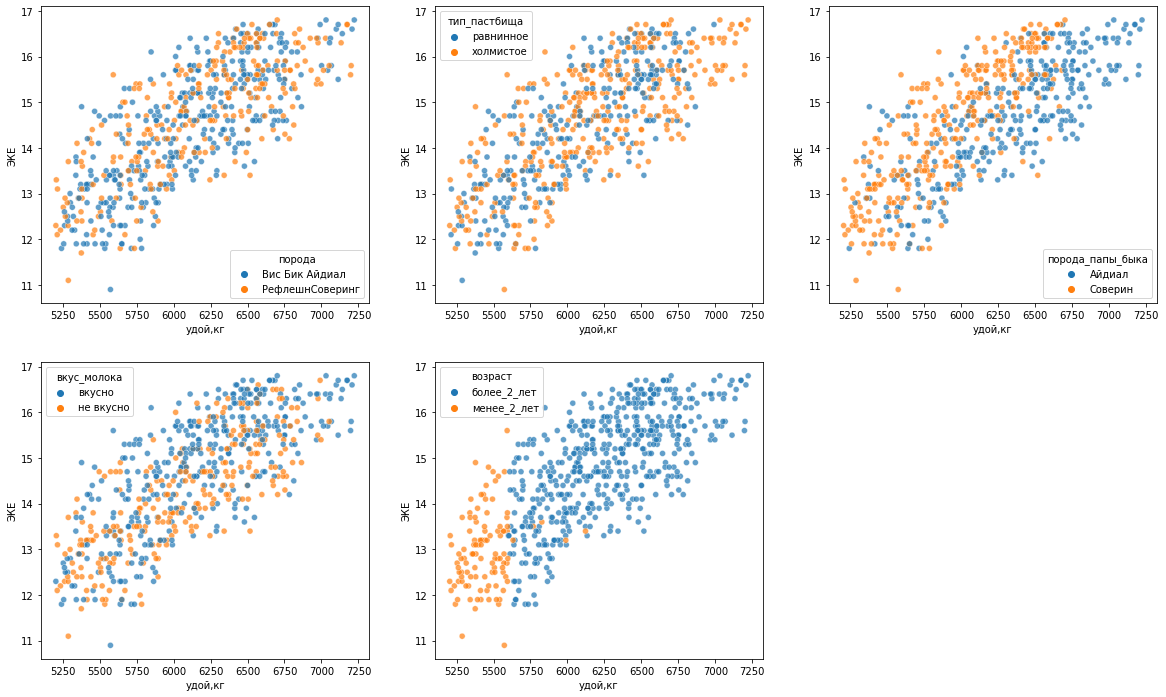

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.delaxes(axes[1,2])

def plot_ydo(corr, tp, i, j):     #создадим функцию для удобства
    sns.scatterplot(data=df_f, x='удой,кг',
                    y=corr,
                    hue=tp,
                    ax=axes[i, j],
                    alpha=(0.7))

plot_ydo('ЭКЕ', 'порода', 0, 0)
plot_ydo('ЭКЕ', 'тип_пастбища', 0, 1)
plot_ydo('ЭКЕ', 'порода_папы_быка', 0, 2)
plot_ydo('ЭКЕ', 'вкус_молока',1 ,0)
plot_ydo('ЭКЕ', 'возраст', 1,1)

**Почти все категориальные признакми распределены по всему графику, кроме ЭКЕ и возраста. Коровы, которым менее 2 лет дают меньше удоя за год, нежели взрослые коровы. Так же больший удой дают коровы, у которых папа имеет попроду Айдиал. Связь сильная и линейна.**

**Теперь рассмотрим удой и сырой протеин.**

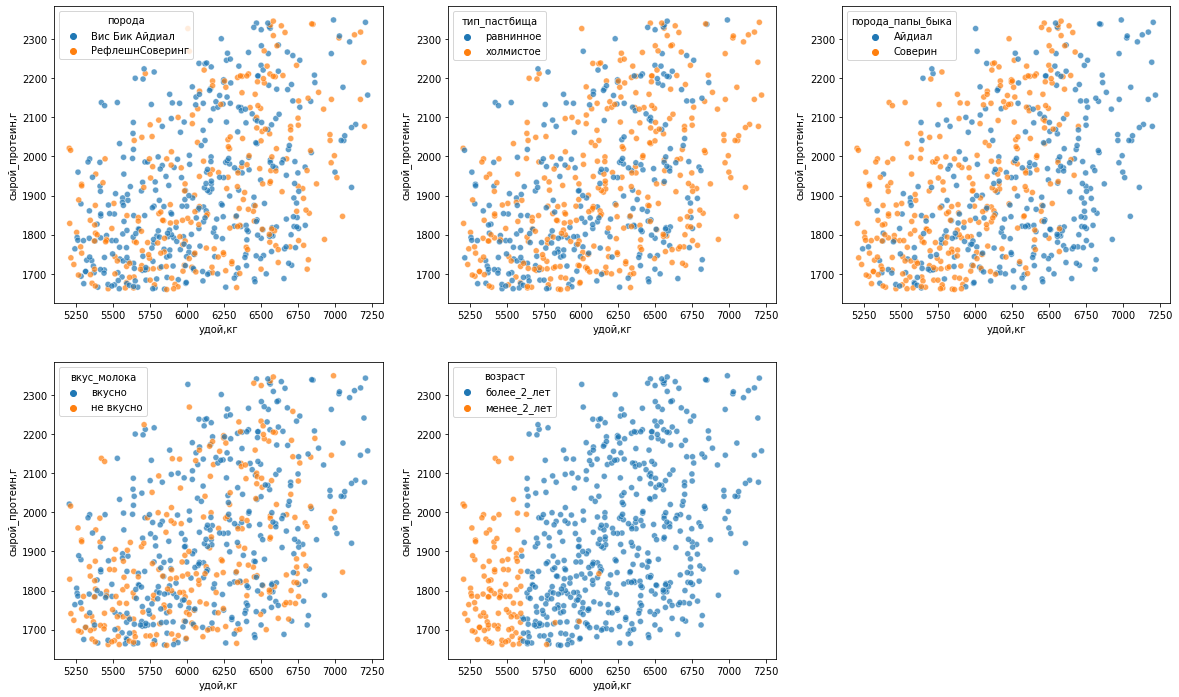

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
fig.delaxes(axes[1,2])

plot_ydo('сырой_протеин,г', 'порода',0 ,0)
plot_ydo('сырой_протеин,г', 'тип_пастбища',0 ,1)
plot_ydo('сырой_протеин,г', 'порода_папы_быка',0 ,2)
plot_ydo('сырой_протеин,г', 'вкус_молока',1 ,0)
plot_ydo('сырой_протеин,г', 'возраст',1 ,1)

**Ситуация остаётся той же - большее количество удоя дают коровы, у которых папа бык имеет породу Айдиал и коровам больше 2 лет. Связь слабая, хоть и линейная.**

**Далее рассмотрим удой и СПО.**

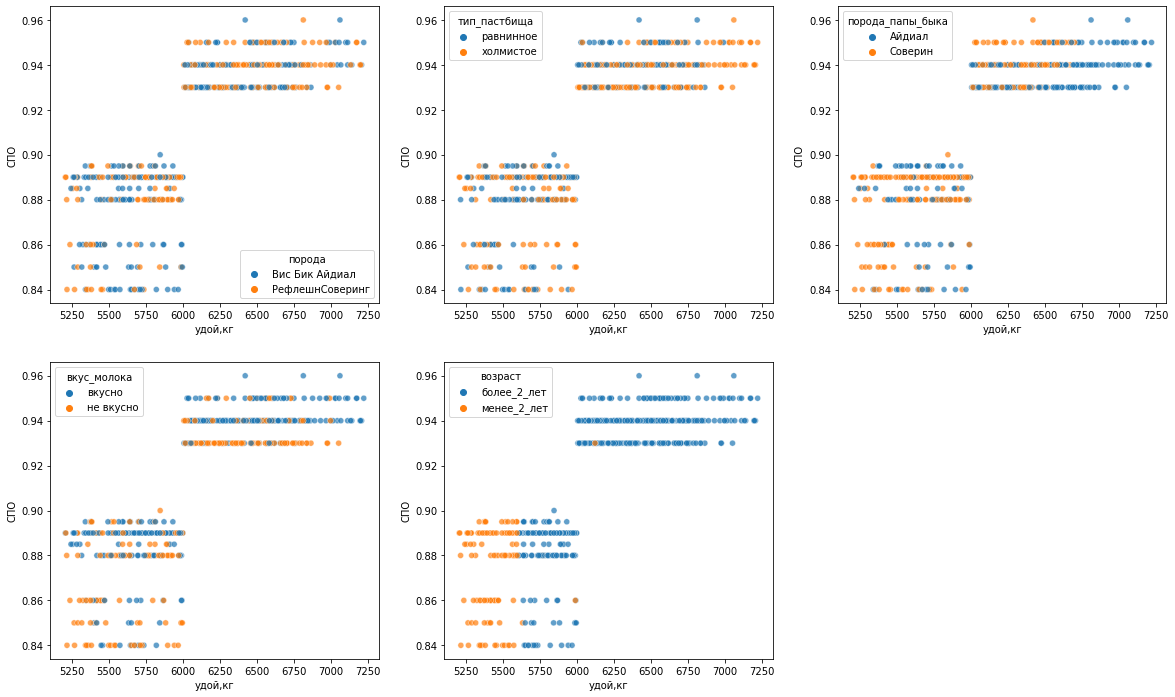

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.delaxes(axes[1,2])

plot_ydo('СПО', 'порода',0 ,0)
plot_ydo('СПО', 'тип_пастбища',0 ,1)
plot_ydo('СПО', 'порода_папы_быка',0 ,2)
plot_ydo('СПО', 'вкус_молока',1 ,0)
plot_ydo('СПО', 'возраст',1 ,1)

**Выводы те же, но связь совсем не линейна, больше смахивает на кластеризацию**

**Рассмотрим удой и жирность.**

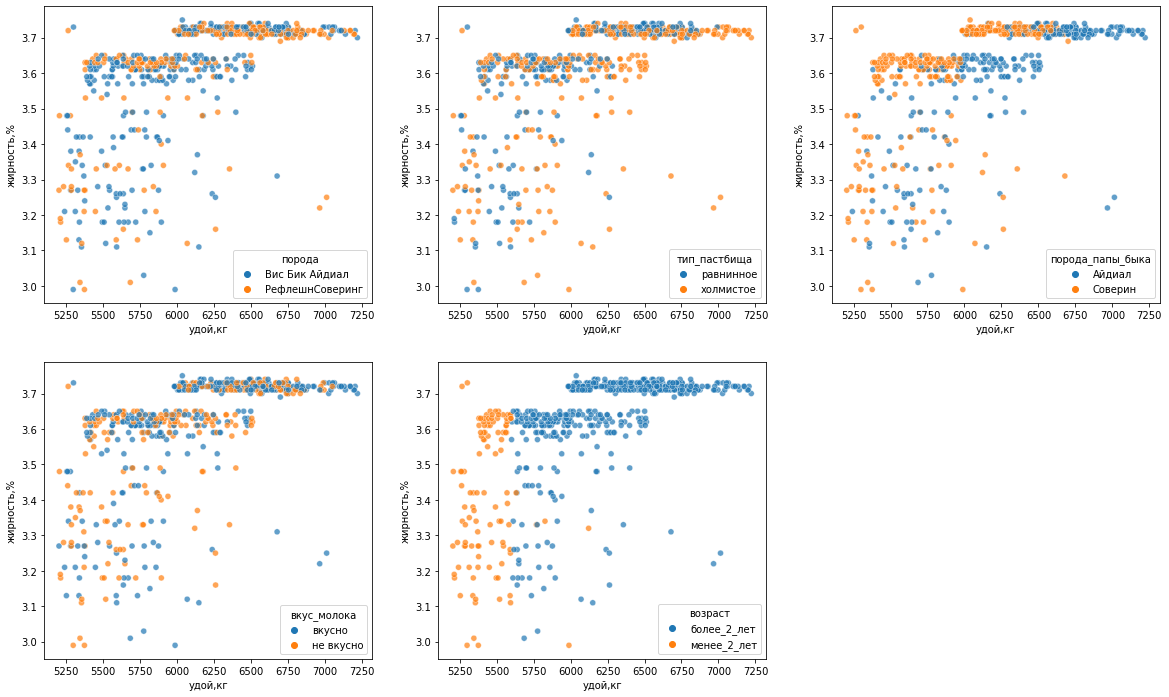

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
fig.delaxes(axes[1,2])

plot_ydo('жирность,%', 'порода',0 ,0)
plot_ydo('жирность,%', 'тип_пастбища',0 ,1)
plot_ydo('жирность,%', 'порода_папы_быка',0 ,2)
plot_ydo('жирность,%', 'вкус_молока',1 ,0)
plot_ydo('жирность,%', 'возраст',1 ,1)

**Ситуация как и с СПО.**

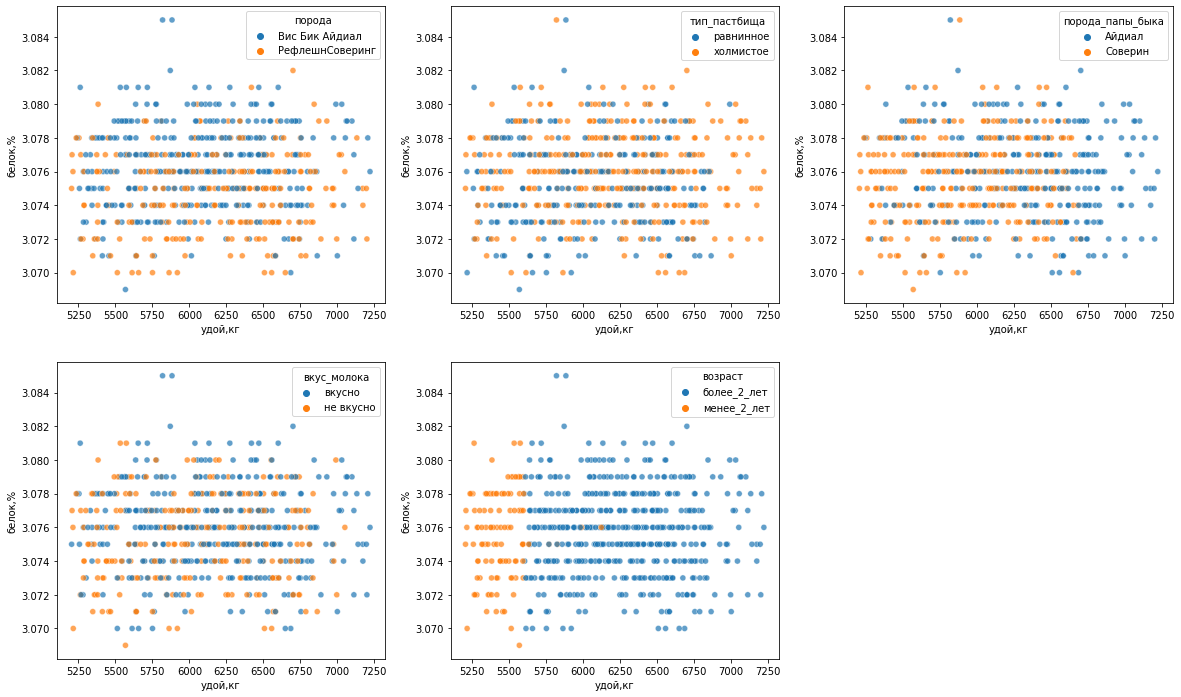

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
fig.delaxes(axes[1,2])

plot_ydo('белок,%', 'порода',0 ,0)
plot_ydo('белок,%', 'тип_пастбища',0 ,1)
plot_ydo('белок,%', 'порода_папы_быка',0 ,2)
plot_ydo('белок,%', 'вкус_молока',1 ,0)
plot_ydo('белок,%', 'возраст',1 ,1)

**Связь линейна, но очень слабая.**

**Можно сделать чётки вывод - больше удоя дают коровы старше 2 лет и те, у кого папа породы Айдиал. Удой имеет связь с СПО, жирностью и белком не линейную связь. Стоит ввести новые признаки и изменить текущие, что мы сделаем позже.**

# Обучение модели линейной регрессии

## Задача регрессии №1

### Подготовка данных

#### Разделение на выборки

**Целевым признаком будет выступать `удой,кг`, входные будут все, кроме `белок,%`, `жирность,%`, `вкус_молока` и `id`, так как это так называемое описание целевого признака, а id не несёт в себе никакой смысловой нагрузки и так же не связан с целевым признаком.**

**Разобьём датасет на тестовую и тренировачную выборки и выведем их размерность. Как мы уже помним, всего 628 строк и 8 колонок в нашем датафрейме.**

In [29]:
df_f_q = df_f.drop(['id', 'белок,%', 'жирность,%', 'вкус_молока'], axis=1)

RANDOM_STATE = 42

X = df_f_q.drop('удой,кг', axis=1)
y = df_f_q['удой,кг']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, random_state=RANDOM_STATE)

display(X_train_1.shape)
display(X_test_1.shape)
display(y_train_1.shape)
y_test_1.shape

(471, 7)

(157, 7)

(471,)

(157,)

- Входные признаки - 471 строка и 7 столбцов
- Целевой признак - 157 строк и 1 столбец

#### Масштабирование данных

**Теперь нам предстоит масштабировать входные признаки, количественные признаки стандартизируем, а категориальные закодируем, заранее отделив их. В конце соберём в один общий датафрейм.**

In [30]:
X_num = ['ЭКЕ', 'сырой_протеин,г', 'СПО']
X_cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']


scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_1[X_num])
X_test_num = scaler.transform(X_test_1[X_num])

encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = encoder.fit_transform(X_train_1[X_cat])
X_test_ohe = encoder.transform(X_test_1[X_cat])

encoder_col_names = encoder.get_feature_names()

X_train_num = pd.DataFrame(X_train_num, columns=X_num)
X_test_num = pd.DataFrame(X_test_num, columns=X_num)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_1 = pd.concat([X_train_num, X_train_ohe], axis=1)
X_test_1 = pd.concat([X_test_num, X_test_ohe], axis=1)

In [31]:
X_train_1.head()

,ЭКЕ,"сырой_протеин,г",СПО,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет
0,1.502378,1.079523,0.837130,1.0,1.0,1.0,0.0
1,-1.557270,-0.196920,-0.703660,1.0,1.0,1.0,1.0
2,0.125537,-1.386085,-1.011818,0.0,0.0,0.0,0.0
3,-0.103937,0.752230,0.837130,0.0,1.0,0.0,0.0
4,-1.098323,0.828598,-0.703660,0.0,0.0,0.0,0.0


**Готово, данные готовы для дальнейшней работы.**

### Обучение и оценка

**Обучим модель линейной регрессии.**

In [32]:
model_lr = LinearRegression()

model_lr.fit(X_train_1, y_train_1)
predict_1 = model_lr.predict(X_test_1)

**Теперь посчитаем коэффициент детерминатции и взглянем на остатки.**

'Коэффицент детерминатции:, 0.7844'

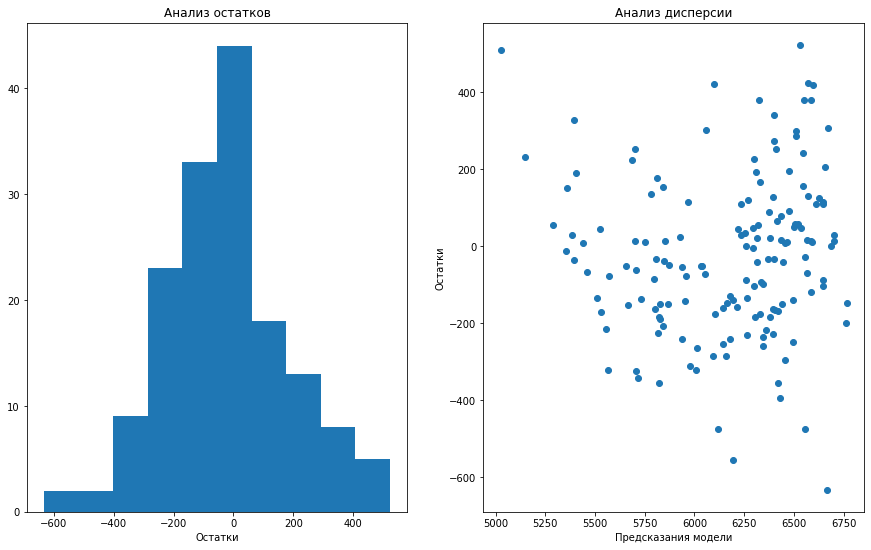

In [33]:
r2 = r2_score(y_test_1, predict_1)
display(f'Коэффицент детерминатции:, {r2:.4f}')

med = y_test_1 - predict_1

fig, axis = plt.subplots(1, 2, figsize=(15, 9))
axis[0].hist(med)
axis[0].set_xlabel('Остатки')
axis[0].set_title('Анализ остатков')

axis[1].scatter(y=med, x=predict_1)
axis[1].set_xlabel('Предсказания модели')
axis[1].set_ylabel('Остатки')
axis[1].set_title('Анализ дисперсии');

**Модель готова:**
- Коэффицент детерминатции равен 0.7844, довольно высокое значение;
- Анализ остатков имеет нормальное распределение.

## Задача регрессии №2

**Зависимость от СПО нелинейная, поэтому при масштабировании мы сдеалем ее категориальным признаком(точнее бинарным), резделив на две части, используя красную линию. С ЭКЕ поступим иначе, возведём её в квадрат и добавим как новый признак, удалив старый.**

### Подготовка данных

**Добавим новый признак `ЭКЕ^2` и сделаем `СПО` бинарным.**

In [34]:
df_f_q['ЭКЕ^2'] = df_f_q['ЭКЕ']**2
df_f_q = df_f_q.drop('ЭКЕ', axis=1)
df_f_q['СПО'] = np.where(df_f_q['СПО'] > 0.91, 1, 0)
df_f_q.head()

,"удой,кг","сырой_протеин,г",СПО,порода,тип_пастбища,порода_папы_быка,возраст,ЭКЕ^2
0,5863,1743,0,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,201.64
1,5529,2138,0,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,163.84
2,5810,1854,0,РефлешнСоверинг,холмистое,Соверин,более_2_лет,196.00
3,5895,2012,0,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,153.76
4,5302,1675,0,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,163.84


#### Разделение на выборки

In [35]:
X = df_f_q.drop('удой,кг', axis=1)
y = df_f_q['удой,кг']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state=RANDOM_STATE)

display(X_train_2.shape)
display(X_test_2.shape)
display(y_train_2.shape)
y_test_2.shape

(471, 7)

(157, 7)

(471,)

(157,)

- Входные признаки - 471 строка и 7 столбцов
- Целевой признак - 157 строк и 1 столбец

#### Масштабирование данных

**Масштабирование будет происходить так же, как и при подготовке первой модели, за исключением того, что СПО сейчас будет бинарным и его масштабировать не стоит.**

In [36]:
X_num = ['сырой_протеин,г', 'ЭКЕ^2']
X_cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
X_bin = ['СПО']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_2[X_num])
X_test_num = scaler.transform(X_test_2[X_num])

encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = encoder.fit_transform(X_train_2[X_cat])
X_test_ohe = encoder.transform(X_test_2[X_cat])

encoder_col_names = encoder.get_feature_names()

X_train_bin = X_train_2[X_bin].reset_index(drop=True)
X_test_bin = X_test_2[X_bin].reset_index(drop=True)

X_train_num = pd.DataFrame(X_train_num, columns=X_num).reset_index(drop=True)
X_test_num = pd.DataFrame(X_test_num, columns=X_num).reset_index(drop=True)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names).reset_index(drop=True)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names).reset_index(drop=True)


X_train_2 = pd.concat([X_train_num, X_train_ohe, X_train_bin], axis=1)
X_test_2 = pd.concat([X_test_num, X_test_ohe, X_test_bin], axis=1)

In [37]:
X_train_2.head()

,"сырой_протеин,г",ЭКЕ^2,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,СПО
0,1.079523,1.577968,1.0,1.0,1.0,0.0,1
1,-0.196920,-1.511438,1.0,1.0,1.0,1.0,0
2,-1.386085,0.082269,0.0,0.0,0.0,0.0,0
3,0.752230,-0.150235,0.0,1.0,0.0,0.0,1
4,0.828598,-1.102358,0.0,0.0,0.0,0.0,0


**Данные готовы.**

### Обучение и оценка

**Обучим модель линейной регрессии.**

In [38]:
model_lr = LinearRegression()

model_lr.fit(X_train_2, y_train_2)
predict_2 = model_lr.predict(X_test_2)

**Теперь посчитаем коэффициент детерминатции и взглянем на остатки.**

'Коэффицент детерминатции:, 0.8181'

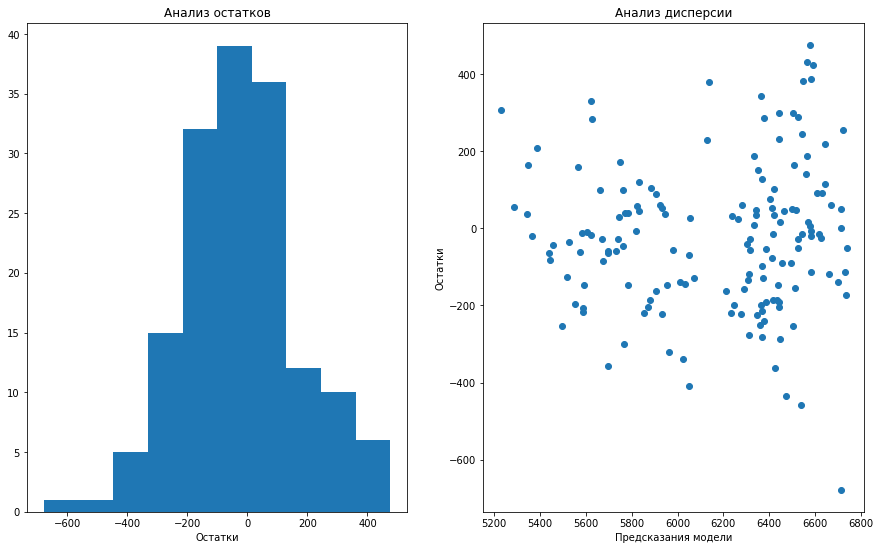

In [39]:
r2 = r2_score(y_test_2, predict_2)
display(f'Коэффицент детерминатции:, {r2:.4f}')

med = y_test_2 - predict_2

fig, axis = plt.subplots(1, 2, figsize=(15, 9))
axis[0].hist(med)
axis[0].set_xlabel('Остатки')
axis[0].set_title('Анализ остатков')

axis[1].scatter(y=med, x=predict_2)
axis[1].set_xlabel('Предсказания модели')
axis[1].set_ylabel('Остатки')
axis[1].set_title('Анализ дисперсии');

- Коэффицент детерминатции равен 0.8181 - результат стал лучше;
- Анализ остаток стал более высокий на нуле, что значит повышение качества модели;
- Дисперсия визуально разделилась на две части;
- Есть один выброс.

## Задача регрессии №3

**Создадим третью модель, но перед этим добавим в наш датафрейм новые признак `имя_папы`**

In [40]:
df_f_q = df_f.merge(df_d, on='id', how='inner')
df_f_q = df_f_q.drop(['id', 'жирность,%', 'белок,%', 'вкус_молока'], axis=1)
df_f_q.head()

,"удой,кг",ЭКЕ,"сырой_протеин,г",СПО,порода,тип_пастбища,порода_папы_быка,возраст,имя_папы
0,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,Буйный
1,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Соловчик
2,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,более_2_лет,Барин
3,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный
4,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Барин


### Подготовка данных

**Сделаем те же операции с признаками, как и при создании второй модели.**

In [41]:
df_f_q['ЭКЕ^2'] = df_f_q['ЭКЕ']**2
df_f_q = df_f_q.drop('ЭКЕ', axis=1)
df_f_q['СПО'] = np.where(df_f_q['СПО'] > 0.91, 1, 0)

#### Разделение на выборки

In [42]:
X = df_f_q.drop('удой,кг', axis=1)
y = df_f_q['удой,кг']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, random_state=RANDOM_STATE)

display(X_train_3.shape)
display(X_test_3.shape)
display(y_train_3.shape)
y_test_3.shape

(471, 8)

(157, 8)

(471,)

(157,)

- Входные признаки - 471 строка и 8 столбцов
- Целевой признак - 157 строк и 1 столбец

#### Масштабирование данных

**Масштабирование будет такое же, только категориальных признаков стало на 1 больше.**

In [43]:
X_num = ['сырой_протеин,г', 'ЭКЕ^2']
X_cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
X_bin = ['СПО']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_3[X_num])
X_test_num = scaler.transform(X_test_3[X_num])

encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = encoder.fit_transform(X_train_3[X_cat])
X_test_ohe = encoder.transform(X_test_3[X_cat])

encoder_col_names = encoder.get_feature_names()

X_train_bin = X_train_3[X_bin].reset_index(drop=True)
X_test_bin = X_test_3[X_bin].reset_index(drop=True)

X_train_num = pd.DataFrame(X_train_num, columns=X_num).reset_index(drop=True)
X_test_num = pd.DataFrame(X_test_num, columns=X_num).reset_index(drop=True)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names).reset_index(drop=True)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names).reset_index(drop=True)


X_train_3 = pd.concat([X_train_num, X_train_ohe, X_train_bin], axis=1)
X_test_3 = pd.concat([X_test_num, X_test_ohe, X_test_bin], axis=1)

In [44]:
X_train_3.head()

,"сырой_протеин,г",ЭКЕ^2,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,СПО
0,1.079523,1.577968,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1
1,-0.196920,-1.511438,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
2,-1.386085,0.082269,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.752230,-0.150235,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,0.828598,-1.102358,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


**Данные готовы.**

### Обучение и оценка

**Обучим модель линейной регрессии.**

In [45]:
model_lr = LinearRegression()

model_lr.fit(X_train_3, y_train_3)
predict_3 = model_lr.predict(X_test_3)

**Теперь посчитаем коэффициент детерминатции и взглянем на остатки.**

'Коэффицент детерминатции:, 0.8248'

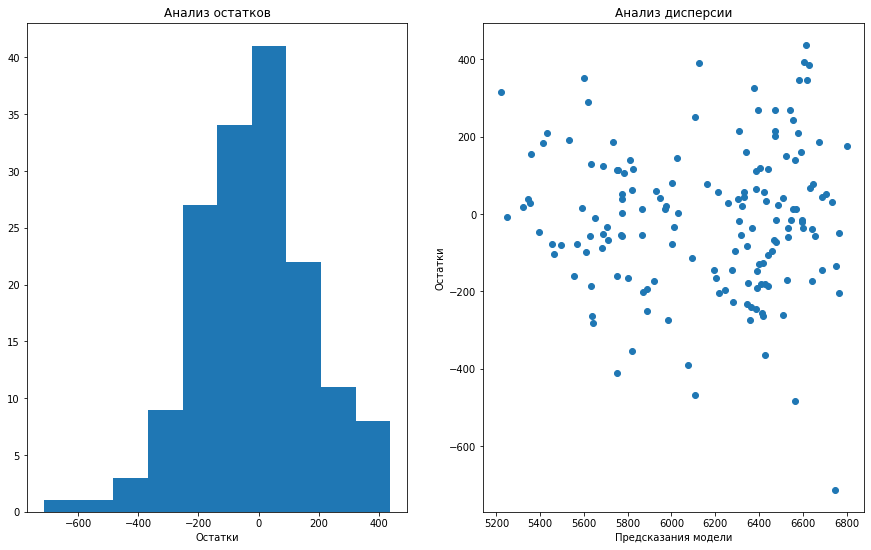

In [46]:
r2 = r2_score(y_test_3, predict_3)
display(f'Коэффицент детерминатции:, {r2:.4f}')

med = y_test_3 - predict_3

fig, axis = plt.subplots(1, 2, figsize=(15, 9))
axis[0].hist(med)
axis[0].set_xlabel('Остатки')
axis[0].set_title('Анализ остатков')

axis[1].scatter(y=med, x=predict_3)
axis[1].set_xlabel('Предсказания модели')
axis[1].set_ylabel('Остатки')
axis[1].set_title('Анализ дисперсии');

**Результат близок ко второй модели, но чуть лучше**
- Коэффицент детерминатции равен 0.8248 - результат улучшился;
- Дисперсия визуально разделилась на две части;
- Есть один выброс.

## Сравнение моделей

**Каждая модель показала неплохие результаты:**
- Дисперсия 1 модели - `0.7844`;
- Дисперсия 2 модели - `0.8181`;
- Дисперсия 3 модели - `0.8248`;

**Распределения у всех нормальные, но у последних двух они более сжаты,а это показатель того, что ошибок меньше. В данный момент 3 модель явно лучшая из всех.**

## Оценка качества

**Оценим качество моделей с помощью 3 метрик: `MSE`, `RMSE` и `MAE`.**

### MSE

**Расчитаем метрику `MSE` для трёх моделей.**

In [47]:
def mse(y_test, y_pred, i):    #сосздадим функцию для подсчёта mse
    mse = mean_squared_error(y_test, y_pred)
    return display(f'Среднеквадратичная ошибка(MSE) для {i} модели = {mse}')

mse(y_test_1, predict_1, 1)
mse(y_test_2, predict_2, 2)
mse(y_test_3, predict_3, 3)

'Среднеквадратичная ошибка(MSE) для 1 модели = 43887.015009660514'

'Среднеквадратичная ошибка(MSE) для 2 модели = 37030.91131113693'

'Среднеквадратичная ошибка(MSE) для 3 модели = 35673.889886181954'

**Самая меньшая среднеквадратичная ошибка у 3 модели.**

### RMSE

**Расчитаем метрику `RMSE` для трёх моделей.**

In [48]:
def rmse(y_test, y_pred, i):    #сосздадим функцию для подсчёта rmse
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return display(f'Корень из среднеквадратичной ошибка(RMSE) для {i} модели = {rmse}')

rmse(y_test_1, predict_1, 1)
rmse(y_test_2, predict_2, 2)
rmse(y_test_3, predict_3, 3)

'Корень из среднеквадратичной ошибка(RMSE) для 1 модели = 209.4922791170608'

'Корень из среднеквадратичной ошибка(RMSE) для 2 модели = 192.43417396901447'

'Корень из среднеквадратичной ошибка(RMSE) для 3 модели = 188.8753289505592'

**Корень среднеквадратичной ошибки меньше всего у 3 модели.**

### MAE

**Расчитаем метрику `MAE` для трёх моделей.**

In [49]:
def mae(y_test, y_pred, i):    #сосздадим функцию для подсчёта rmse
    mae = mean_absolute_error(y_test, y_pred)
    return display(f'Средняя абсолютная ошибка для {i} модели = {mae}')

mae(y_test_1, predict_1, 1)
mae(y_test_2, predict_2, 2)
mae(y_test_3, predict_3, 3)

'Средняя абсолютная ошибка для 1 модели = 164.24194463474925'

'Средняя абсолютная ошибка для 2 модели = 149.03965222364596'

'Средняя абсолютная ошибка для 3 модели = 146.16302445362322'

**Средняя абсолютная ошибка ниже у 3 модели, её мы и выберем.**

**Теперь укажем доверительный интервал для нашей лучшей модели.**

In [50]:
predict_train_3 = model_lr.predict(X_train_3)

med = y_train_3 - predict_train_3

lower = np.quantile(med, 0.025)
upper = np.quantile(med, 0.975)

print(f"95% доверительный интервал ошибок: [{lower:.2f}, {upper:.2f}]")

ci_lower = predict_3 + lower
ci_upper = predict_3 + upper

print(f"Прогноз: {predict_3[0]:.2f}")
print(f"95% интервал: [{ci_lower[0]:.2f}, {ci_upper[0]:.2f}]")

95% доверительный интервал ошибок: [-355.99, 363.24]
Прогноз: 6013.25
95% интервал: [5657.26, 6376.49]


**Доверительный интервал = [-318.23, 397.38]**

## Прогноз удоя коров

**Теперь нам предстоит спрогнозировать удой коров, которые фермер собирается купить. Но перед этим масштабируем данные и добавим туда столбцы `сырой_протеин,г`, `ЭКЕ^2` и `СПО` и увеличим их на 5%(кроме СПО - он бинарный).**

In [51]:
df_f_q

,"удой,кг","сырой_протеин,г",СПО,порода,тип_пастбища,порода_папы_быка,возраст,имя_папы,ЭКЕ^2
0,5863,1743,0,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,Буйный,201.64
1,5529,2138,0,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Соловчик,163.84
2,5810,1854,0,РефлешнСоверинг,холмистое,Соверин,более_2_лет,Барин,196.00
3,5895,2012,0,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный,153.76
4,5302,1675,0,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Барин,163.84
...,...,...,...,...,...,...,...,...,...
623,6812,1964,1,РефлешнСоверинг,равнинное,Айдиал,более_2_лет,Буйный,237.16
624,5513,1700,0,РефлешнСоверинг,равнинное,Соверин,менее_2_лет,Барин,166.41
625,5970,1837,0,РефлешнСоверинг,холмистое,Соверин,более_2_лет,Барин,207.36
626,5746,1994,0,РефлешнСоверинг,равнинное,Соверин,более_2_лет,Барин,190.44


In [52]:
q1 = df_f_q['ЭКЕ^2'].mean()
q2 = df_f_q['сырой_протеин,г'].mean()*1.05
df_c['сырой_протеин,г'] = q2
df_c['ЭКЕ^2'] = q1*1.05
df_c['СПО'] = 1
display(df_c.head())
X_train_3.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,"сырой_протеин,г",ЭКЕ^2,СПО
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,224.025225,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,224.025225,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,224.025225,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,224.025225,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,224.025225,1


,"сырой_протеин,г",ЭКЕ^2,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,СПО
0,1.079523,1.577968,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1
1,-0.196920,-1.511438,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
2,-1.386085,0.082269,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.752230,-0.150235,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,0.828598,-1.102358,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


**Теперь масштабируем данные в датафрейме.**

In [53]:
X_num = ['сырой_протеин,г', 'ЭКЕ^2']
X_cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
X_bin = ['СПО']

X_train_num = scaler.transform(df_c[X_num])

X_train_ohe = encoder.transform(df_c[X_cat])

encoder_col_names = encoder.get_feature_names()

X_train_bin = df_c[X_bin].reset_index(drop=True)

X_train_num = pd.DataFrame(X_train_num, columns=X_num).reset_index(drop=True)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names).reset_index(drop=True)


df_c_mod_1 = pd.concat([X_train_num, X_train_ohe, X_train_bin], axis=1)


In [54]:
df_c_mod_1.head()

,"сырой_протеин,г",ЭКЕ^2,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,СПО
0,0.517384,0.293607,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
1,0.517384,0.293607,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
2,0.517384,0.293607,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.517384,0.293607,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,0.517384,0.293607,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


**Теперь получим прогноз.**

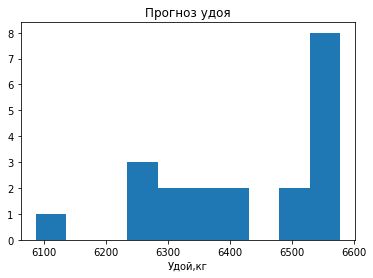

In [55]:
predict_mod_1 = model_lr.predict(df_c_mod_1)
plt.hist(x=predict_mod_1)
plt.title('Прогноз удоя')
plt.xlabel('Удой,кг');

**Прогнозы радуют, все коровы дадут больше 6000кг удоя за год. График поделился на 3 группы - это нормально, ведь коров было мало.**

# Обучение модели логистической регрессии

## Разделение на выборки

**Задача классификации. Возьмём готовые данные и сделаем целевым признаком вкус молока. Будем использовать модель логистической регрессии.**

**Сделаем целевой признак(вкус молока) бинарным. Жирность и белок удалять не будем, так как он связан со вкусом, но уберём удой, его нет в датафрейме с интересующими нас коровами. Так же переименуем некоторые признаки.**

In [56]:
df_f_mod_2 = df_f
df_f_mod_2 = df_f_mod_2.merge(df_d, on='id', how='inner')

df_f_mod_2['СПО'] = df_f_mod_2['СПО'].apply(lambda x: 1 if x>0.91 else 0)
df_f_mod_2['вкус_молока'] = df_f_mod_2['вкус_молока'].apply(lambda x: 1 if x=='вкусно' else 0)
df_f_mod_2['ЭКЕ^2'] = df_f_mod_2['ЭКЕ']**2
df_f_mod_2 = df_f_mod_2.drop(['ЭКЕ', 'id', 'удой,кг'], axis=1)



df_c = df_c.rename(columns={'текущая_жирность,%': 'жирность,%',
                           'текущий_уровень_белок,%': 'белок,%'})

display(df_f_mod_2.head())
df_c.head()

,"сырой_протеин,г",СПО,порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст,имя_папы,ЭКЕ^2
0,1743,0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,Буйный,201.64
1,2138,0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,Соловчик,163.84
2,1854,0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,более_2_лет,Барин,196.00
3,2012,0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,более_2_лет,Буйный,153.76
4,1675,0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,Барин,163.84


,порода,тип_пастбища,порода_папы_быка,имя_папы,"жирность,%","белок,%",возраст,"сырой_протеин,г",ЭКЕ^2,СПО
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,224.025225,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,224.025225,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,224.025225,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,224.025225,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,224.025225,1


In [57]:
X = df_f_mod_2.drop('вкус_молока', axis=1)
y = df_f_mod_2['вкус_молока']
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X, y, stratify=y,
                                                            random_state=RANDOM_STATE)

display(X_train_k.shape)
display(X_test_k.shape)
display(y_train_k.shape)
y_test_k.shape

(471, 10)

(157, 10)

(471,)

(157,)

- Входные признаки - 471 строка и 10 столбцов
- Целевой признак - 157 строк и 1 столбец

## Масштабирование данных

**Масштабируем категориальные и количественные признаки.**

In [58]:
X_num = ['ЭКЕ^2', 'сырой_протеин,г', 'жирность,%',
         'белок,%']
X_cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
X_bin = ['СПО']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_k[X_num])
X_test_num = scaler.transform(X_test_k[X_num])

encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = encoder.fit_transform(X_train_k[X_cat])
X_test_ohe = encoder.transform(X_test_k[X_cat])

encoder_col_names = encoder.get_feature_names()

X_train_bin = X_train_k[X_bin].reset_index(drop=True)
X_test_bin = X_test_k[X_bin].reset_index(drop=True)

X_train_num = pd.DataFrame(X_train_num, columns=X_num).reset_index(drop=True)
X_test_num = pd.DataFrame(X_test_num, columns=X_num).reset_index(drop=True)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names).reset_index(drop=True)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names).reset_index(drop=True)


X_train_k = pd.concat([X_train_num, X_train_ohe, X_train_bin], axis=1)
X_test_k = pd.concat([X_test_num, X_test_ohe, X_test_bin], axis=1)

In [59]:
X_train_k.head()

,ЭКЕ^2,"сырой_протеин,г","жирность,%","белок,%",x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,СПО
0,-1.259928,-1.222334,0.188714,-0.993359,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
1,0.148488,-0.947910,0.684928,0.156204,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1
2,-1.328703,-0.843629,-0.803713,-1.376546,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,-0.542741,0.391278,0.064661,0.156204,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.148488,1.192596,0.684928,0.156204,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1


**Данные готовы для работы.**

## Обучение и метрики

**Обучим модель и покажем матрицу ошибок.**

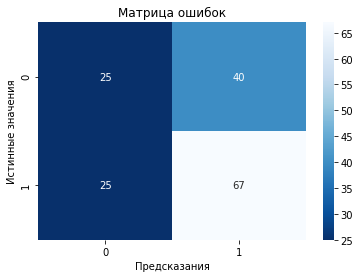

In [60]:
clf = LogisticRegression()
clf = clf.fit(X_train_k, y_train_k)
predict = clf.predict(X_test_k)

mat = confusion_matrix(y_test_k, predict)

sns.heatmap(mat, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания');

**Готово, теперь приступим к оценки качества модели с помощью метрик `accuracy`, `recall` и `precision`.**

In [61]:
accuracy = accuracy_score(y_test_k, predict)
display(f'Значение accuracy: {accuracy:4f}')

recall = recall_score(y_test_k, predict, pos_label=1)
display(f'Значение recall: {recall:4f}')

precision = precision_score(y_test_k, predict, pos_label=1)
display(f'Значение precision: {precision:4f}')

'Значение accuracy: 0.585987'

'Значение recall: 0.728261'

'Значение precision: 0.626168'

**Метрики не особо радуют**

## Анализ модели

**Так как нам важно отобрать хороших коров, на важна ошибка второго рода, чтобы модель нечаянно не присваивала плохим коровам хорошую оценку - нам нужно снизить False Positive(precision).**

In [62]:
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=4, endpoint=False)]
y_proba = clf.predict_proba(X_test_k)[:, 1]  # Сохраняем вероятности в отдельную переменную

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)  # Каждый раз работаем с исходными вероятностями
    print(f"Порог = {thresh}:")
    print("Precision:", precision_score(y_test_k, y_pred))
    print("Recall:", recall_score(y_test_k, y_pred))
    print('-------')

Порог = 0.1:
Precision: 0.5859872611464968
Recall: 1.0
-------
Порог = 0.32:
Precision: 0.5704225352112676
Recall: 0.8804347826086957
-------
Порог = 0.55:
Precision: 0.6494845360824743
Recall: 0.6847826086956522
-------
Порог = 0.78:
Precision: 0.9545454545454546
Recall: 0.22826086956521738
-------


**Нам  нужно максимально уменьшить порог класификации, чтобы точно не ошибиться и взять нужную корову - возьмём 0.78.**

## Прогноз вкуса

**Сделаем предобработку и выведем прогнозы с новым порогом классификации.**

In [63]:
thres = 0.78
X_new = df_c[['ЭКЕ^2', 'сырой_протеин,г', 'жирность,%', 'белок,%', 
             'порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы', 'СПО']]


X_new_num = pd.DataFrame(
    scaler.transform(X_new[X_num]),
    columns=X_num
).reset_index(drop=True)

X_new_cat = pd.DataFrame(
    encoder.transform(X_new[X_cat]),
    columns=encoder.get_feature_names()
).reset_index(drop=True)

X_new_bin = X_new[X_bin].reset_index(drop=True)

X_new_processed = pd.concat([X_new_num, X_new_cat, X_new_bin], axis=1)

y_proba_new = clf.predict_proba(X_new_processed)[:, 1]
df_c['ожидаемый_вкус_молока'] = (y_proba_new > thres).astype(int)

display(df_c[['ожидаемый_вкус_молока'] + X_new.columns.tolist()])

,ожидаемый_вкус_молока,ЭКЕ^2,"сырой_протеин,г","жирность,%","белок,%",порода,тип_пастбища,порода_папы_быка,возраст,имя_папы,СПО
0,0,224.025225,2019.947532,3.58,3.076,Вис Бик Айдиал,холмистое,Айдиал,более_2_лет,Геркулес,1
1,0,224.025225,2019.947532,3.54,3.081,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Буйный,1
2,0,224.025225,2019.947532,3.59,3.074,РефлешнСоверинг,равнинное,Соверин,более_2_лет,Барин,1
3,0,224.025225,2019.947532,3.40,3.061,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный,1
4,0,224.025225,2019.947532,3.64,3.074,РефлешнСоверинг,равнинное,Айдиал,более_2_лет,Буйный,1
5,0,224.025225,2019.947532,3.63,3.053,РефлешнСоверинг,равнинное,Соверин,менее_2_лет,Геркулес,1
6,0,224.025225,2019.947532,3.58,3.076,Вис Бик Айдиал,холмистое,Айдиал,более_2_лет,Геркулес,1
7,0,224.025225,2019.947532,3.57,3.079,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,Буйный,1
8,0,224.025225,2019.947532,3.59,3.074,РефлешнСоверинг,равнинное,Соверин,более_2_лет,Барин,1
9,0,224.025225,2019.947532,3.40,3.079,РефлешнСоверинг,холмистое,Айдиал,менее_2_лет,Буйный,1


In [64]:
df_c['ожидаемый_вкус_молока'] = df_c['ожидаемый_вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
df_c.query('ожидаемый_вкус_молока == "вкусно"')

,порода,тип_пастбища,порода_папы_быка,имя_папы,"жирность,%","белок,%",возраст,"сырой_протеин,г",ЭКЕ^2,СПО,ожидаемый_вкус_молока


**К сожалению, порог был слишком высок для нашиих коров - ни одна из них нам не подошла, их молоко было не вкусным. Возможно, если бы мы понизили порок до 0.6, часть коров бы подошли, но зачем нам их невкусное молоко.**

# Итоговые выводы

**Добавим наши предсказания в изначальный датафрейм с выбраннами коровами.**

In [65]:
df_c['ожидаемый_удой,кг'] = predict_mod_1
df_c

,порода,тип_пастбища,порода_папы_быка,имя_папы,"жирность,%","белок,%",возраст,"сырой_протеин,г",ЭКЕ^2,СПО,ожидаемый_вкус_молока,"ожидаемый_удой,кг"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,224.025225,1,не вкусно,6569.542943
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,224.025225,1,не вкусно,6338.334675
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,224.025225,1,не вкусно,6243.623422
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,224.025225,1,не вкусно,6552.713023
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,224.025225,1,не вкусно,6501.769713
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,2019.947532,224.025225,1,не вкусно,6385.003864
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,224.025225,1,не вкусно,6569.542943
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,224.025225,1,не вкусно,6530.883383
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,224.025225,1,не вкусно,6243.623422
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,224.025225,1,не вкусно,6360.164314


**Все коровы дадут больше 6000кг удоя, но молоко у них не вкусное, фермеру стоит рассмотреть других коров.**

**Модель линейной регрессии мы улучшили с помощью новых признаков(ЭКЕ в квадрате), а так же сделали бинарным признак СПО. Возможно, если бы данных было больше, модель работала бы лучше. Так же стоило бы подобрать такие признаки, которые высоко и линейно связаны с таргетом.**

**При расчёте рисков важно знать метрики во время использования моделей классификации, всё зависит от того, что нам нужно. Если нам нужны коровы с вкусным молоком(как в нашей задаче), нам стоит повысить порог классификации и более жестко отбирать коров, чтобы нам не попались коровы с не вкусным молоком.**